In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.4 MB/s eta 0:00:00


Data shape: (11162, 17)
Columns: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit']
   age         job  marital  education default  balance housing loan  contact  \
0   59      admin.  married  secondary      no     2343     yes   no  unknown   
1   56      admin.  married  secondary      no       45      no   no  unknown   
2   41  technician  married  secondary      no     1270     yes   no  unknown   

   day month  duration  campaign  pdays  previous poutcome deposit  
0    5   may      1042         1     -1         0  unknown     yes  
1    5   may      1467         1     -1         0  unknown     yes  
2    5   may      1389         1     -1         0  unknown     yes  
Categorical (9): ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
Numerical (7): ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previ

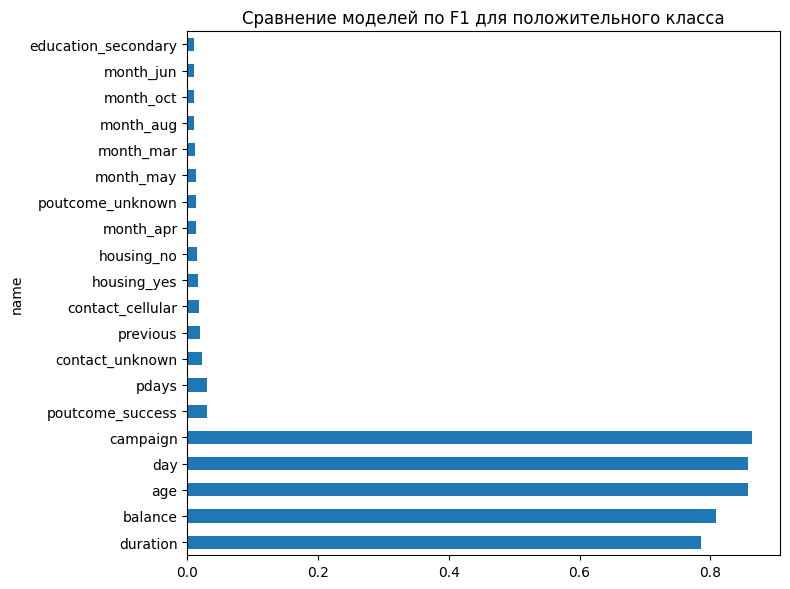

In [6]:
# id: 31001, variant: standard/chat_message, title: Bank Marketing pipeline

import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from catboost import CatBoostClassifier, Pool
import xgboost as xgb
import matplotlib.pyplot as plt
import joblib

RANDOM_STATE = 42
CSV_PATHS = ["bank.csv"]
MODEL_OUT_DIR = Path("models_out")
MODEL_OUT_DIR.mkdir(exist_ok=True)
TEST_SIZE = 0.2
DO_HYPERSEARCH = False
N_JOBS = -1

def load_csv_try(paths):
    for p in paths:
        if Path(p).exists():
            return pd.read_csv(p)
    raise FileNotFoundError(f"Не найден ни один из файлов: {paths}. Поместите bunk.csv рядом со скриптом.")

df = load_csv_try(CSV_PATHS)
print("Data shape:", df.shape)
print("Columns:", df.columns.tolist())

print(df.head(3))

TARGET_COL = 'deposit'
if TARGET_COL not in df.columns:
    possible = [c for c in df.columns if c.lower() in ('deposit', 'y', 'subscribed', 'target')]
    if possible:
        TARGET_COL = possible[0]
    else:
        raise ValueError("Не найдена целевая колонка (deposit). Переименуйте её или укажите явно в коде.")

df[TARGET_COL] = df[TARGET_COL].astype(str).str.strip().str.lower()
pos_label = 'yes'
df['y_bin'] = (df[TARGET_COL] == pos_label).astype(int)

X = df.drop(columns=[TARGET_COL, 'y_bin'])
y = df['y_bin']

cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
print(f"Categorical ({len(cat_cols)}):", cat_cols)
print(f"Numerical ({len(num_cols)}):", num_cols)

high_card = [c for c in cat_cols if X[c].nunique() > 20]
low_card = [c for c in cat_cols if X[c].nunique() <= 20]
print("High-cardinality categorical:", high_card)
print("Low-cardinality categorical:", low_card)

preprocessor = ColumnTransformer(transformers=[
    ('num', 'passthrough', num_cols),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False), low_card),
    ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), high_card)
], remainder='drop')


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)
print("Train/test shapes:", X_train.shape, X_test.shape, y_train.sum(), "/", y_test.sum())

def fit_and_eval(pipeline, X_train, y_train, X_test, y_test, name="model", save_model=True):
    print(f"\n=== TRAIN & EVAL: {name} ===")
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    report = classification_report(y_test, y_pred, digits=4, output_dict=True)
    print(classification_report(y_test, y_pred, digits=4))
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion matrix:\n", cm)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_pos = f1_score(y_test, y_pred, pos_label=1)
    prec_pos = precision_score(y_test, y_pred, pos_label=1)
    rec_pos = recall_score(y_test, y_pred, pos_label=1)
    summary = {
        'name': name,
        'f1_macro': f1_macro,
        'f1_pos': f1_pos,
        'precision_pos': prec_pos,
        'recall_pos': rec_pos
    }
    if save_model:
        joblib.dump(pipeline, MODEL_OUT_DIR / f"{name}.joblib")
    return summary, report


results = []

dt_clf = DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')
dt_pipe = Pipeline([('pre', preprocessor), ('clf', dt_clf)])
res_dt, report_dt = fit_and_eval(dt_pipe, X_train, y_train, X_test, y_test, name="decision_tree")
results.append(res_dt)

rf_clf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, class_weight='balanced', n_jobs=N_JOBS)
rf_pipe = Pipeline([('pre', preprocessor), ('clf', rf_clf)])
res_rf, report_rf = fit_and_eval(rf_pipe, X_train, y_train, X_test, y_test, name="random_forest")
results.append(res_rf)

adb_clf = AdaBoostClassifier(n_estimators=100, random_state=RANDOM_STATE)
adb_pipe = Pipeline([('pre', preprocessor), ('clf', adb_clf)])
res_adb, report_adb = fit_and_eval(adb_pipe, X_train, y_train, X_test, y_test, name="adaboost")
results.append(res_adb)

X_pre = preprocessor.fit_transform(X_train)
X_pre_test = preprocessor.transform(X_test)
dtrain = xgb.DMatrix(X_pre, label=y_train)
dtest = xgb.DMatrix(X_pre_test, label=y_test)
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'use_label_encoder': False,
    'seed': RANDOM_STATE,
    'verbosity': 0,
}
xgb_clf = xgb.XGBClassifier(**{k:v for k,v in xgb_params.items() if k!='verbosity'}, n_estimators=200, n_jobs=N_JOBS, random_state=RANDOM_STATE)
xgb_clf.fit(X_pre, y_train)
y_pred_xgb = xgb_clf.predict(X_pre_test)
from sklearn.metrics import classification_report as cr
print("\n=== XGBoost ===")
print(cr(y_test, y_pred_xgb, digits=4))
res_xgb = {
    'name': 'xgboost',
    'f1_macro': f1_score(y_test, y_pred_xgb, average='macro'),
    'f1_pos': f1_score(y_test, y_pred_xgb, pos_label=1),
    'precision_pos': precision_score(y_test, y_pred_xgb, pos_label=1),
    'recall_pos': recall_score(y_test, y_pred_xgb, pos_label=1)
}
joblib.dump((preprocessor, xgb_clf), MODEL_OUT_DIR / "xgboost_preproc_clf.joblib")
results.append(res_xgb)

cat_idx = [i for i, col in enumerate(X.columns) if col in cat_cols]
cb_clf = CatBoostClassifier(iterations=500, learning_rate=0.05, eval_metric='F1', random_seed=RANDOM_STATE, verbose=False)
cb_clf.fit(X_train, y_train, cat_features=cat_idx)
y_pred_cb = cb_clf.predict(X_test).astype(int)
print("\n=== CatBoost ===")
print(cr(y_test, y_pred_cb, digits=4))
res_cb = {
    'name': 'catboost',
    'f1_macro': f1_score(y_test, y_pred_cb, average='macro'),
    'f1_pos': f1_score(y_test, y_pred_cb, pos_label=1),
    'precision_pos': precision_score(y_test, y_pred_cb, pos_label=1),
    'recall_pos': recall_score(y_test, y_pred_cb, pos_label=1)
}
cb_clf.save_model(str(MODEL_OUT_DIR / "catboost.cbm"))
results.append(res_cb)

res_df = pd.DataFrame(results).set_index('name')
print("\n=== SUMMARY ===")
print(res_df.sort_values('f1_pos', ascending=False))

plt.figure(figsize=(8,5))
res_df['f1_pos'].sort_values(ascending=True).plot.barh()
plt.xlabel("F1 (positive class = подписка)")
plt.title("Сравнение моделей по F1 для положительного класса")
plt.tight_layout()
plt.savefig("model_f1_pos.png")
print("Saved chart: model_f1_pos.png")

feature_names = []
feature_names += num_cols
ohe = preprocessor.named_transformers_['ohe']
if hasattr(ohe, 'get_feature_names_out'):
    ohe_names = list(ohe.get_feature_names_out(low_card))
else:
    ohe_names = []
feature_names += ohe_names
feature_names += high_card

rf_model = rf_clf
try:
    importances = rf_model.feature_importances_
    if len(importances) == len(feature_names):
        imp_df = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(30)
        print("\nTop features (RandomForest):")
        print(imp_df)
        imp_df.head(20).plot.barh(figsize=(8,6))
        plt.tight_layout()
        plt.savefig("rf_feature_importance.png")
        print("Saved: rf_feature_importance.png")
    else:
        print("Не совпадает длина feature_importances_ и feature_names; пропускаю вывод.")
except Exception as e:
    print("Ошибка при RF importances:", e)

try:
    xgb_imp = xgb_clf.get_booster().get_score(importance_type='gain')
    xgb_imp_s = pd.Series(xgb_imp).sort_values(ascending=False).head(30)
    print("\nTop features (XGBoost, raw indices):")
    print(xgb_imp_s)
except Exception as e:
    print("Ошибка при XGBoost importance:", e)

try:
    cb_imp = cb_clf.get_feature_importance(prettified=True)
    print("\nCatBoost feature importance (top):")
    print(cb_imp[:20])
except Exception as e:
    print("Ошибка при CatBoost importance:", e)

best_by_f1pos = res_df['f1_pos'].idxmax()
print(f"\nRecommendation: лучшая модель по F1 для положительного класса: {best_by_f1pos}")

res_df.to_csv("models_comparison_summary.csv")
print("Saved summary to models_comparison_summary.csv")

